In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# ==============================================
# 1. Core Components (Custom Layers)
# ==============================================
class InstanceNormalization(layers.Layer):
    """Custom Instance Normalization Layer"""
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=(input_shape[-1],),
            initializer='ones')
        self.offset = self.add_weight(
            name='offset',
            shape=(input_shape[-1],),
            initializer='zeros')

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        return self.scale * (inputs - mean) * inv + self.offset

class ReflectionPadding2D(tf.keras.layers.Layer):
    """Custom Reflection Padding Layer"""
    def __init__(self, padding=(1, 1), **kwargs):
        super().__init__(**kwargs)
        self.padding = tuple(padding)

    def call(self, input_tensor):
        pw, ph = self.padding
        return tf.pad(input_tensor, [[0, 0], [ph, ph], [pw, pw], [0, 0]], mode='REFLECT')

    def get_config(self):
        config = super().get_config()
        config.update({"padding": self.padding})
        return config


# ==============================================
# 2. Bio-Physical & Neuro-Symbolic Components
# ==============================================
class BioPhysicalLayer(layers.Layer):
    """Enforces tissue physics between CT and MRI"""
    def call(self, inputs):
        ct, mri = inputs
        # CT Hounsfield Units to tissue masks
        bone_mask = tf.cast(ct > 0.7, tf.float32)       # Bones (HU > 700)
        tissue_mask = tf.cast(ct > -0.1, tf.float32)    # Soft tissues
        
        # Physics constraints
        mri_bone = mri * bone_mask * 0.8     # Bones darker in MRI
        mri_tissue = mri * tissue_mask * 1.2  # Soft tissue brighter
        return mri_bone + mri_tissue + (1.0 - tf.maximum(bone_mask, tissue_mask)) * mri

class NeuroSymbolicLayer(layers.Layer):
    """Incorporates anatomical rules"""
    def build(self, input_shape):
        self.ventricle_kernel = self.add_weight(
            name='ventricle_kernel',
            shape=(3, 3, 1, 1),
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02))
        
    def call(self, inputs):
        ct, mri = inputs
        # Ventricle detection (learned)
        ventricle_map = tf.nn.conv2d(ct, self.ventricle_kernel, strides=1, padding='SAME')
        ventricle_map = tf.sigmoid(ventricle_map * 10)
        
        # Anatomical adjustment
        return mri * (1.0 - ventricle_map * 0.3)  # Darken ventricles

# ==============================================
# 3. Enhanced Generator Architecture
# ==============================================
def residual_block(x):
    """Residual block with instance normalization"""
    dim = x.shape[-1]
    input_tensor = x
    
    x = ReflectionPadding2D((1, 1))(x)
    x = layers.Conv2D(dim, 3, padding='valid', use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    
    x = ReflectionPadding2D((1, 1))(x)
    x = layers.Conv2D(dim, 3, padding='valid', use_bias=False)(x)
    x = InstanceNormalization()(x)
    
    return layers.Add()([input_tensor, x])

def build_bpnsgm_generator(input_shape=(256, 256, 1)):
    """Generator with Bio-Physical and Neuro-Symbolic layers"""
    ct_input = layers.Input(shape=input_shape)
    
    # Encoder
    x = ReflectionPadding2D((3, 3))(ct_input)
    x = layers.Conv2D(64, 7, padding='valid', use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(128, 3, strides=2, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(256, 3, strides=2, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    
    # Transformers
    for _ in range(9):
        x = residual_block(x)
    
    # Decoder
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    
    # Initial output
    x = ReflectionPadding2D((3, 3))(x)
    x = layers.Conv2D(1, 7, padding='valid')(x)
    initial_mri = layers.Activation('tanh')(x)
    
    # Bio-Physical and Neuro-Symbolic Processing
    physical_mri = BioPhysicalLayer()([ct_input, initial_mri])
    final_mri = NeuroSymbolicLayer()([ct_input, physical_mri])
    
    return Model(ct_input, final_mri)

# ==============================================
# 4. PatchGAN Discriminator
# ==============================================
def build_discriminator(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(512, 4, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    outputs = layers.Conv2D(1, 4, padding='same')(x)
    
    return Model(inputs, outputs)

# ==============================================
# 5. BP-NSGM Enhanced CycleGAN
# ==============================================
class BPNSGM_CycleGAN(keras.Model):
    def __init__(self):
        super().__init__()
        self.G_CT2MRI = build_bpnsgm_generator()
        self.G_MRI2CT = build_bpnsgm_generator()
        self.D_CT = build_discriminator()
        self.D_MRI = build_discriminator()
        
        # Loss weights
        self.lambda_cycle = 10.0
        self.lambda_id = 5.0
        self.lambda_bio = 2.0
        self.lambda_symbolic = 1.0

    def compile(self, g_optimizer, d_optimizer):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = keras.losses.MeanSquaredError()
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.bio_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        real_ct, real_mri = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Forward translation
            fake_mri = self.G_CT2MRI(real_ct, training=True)
            fake_ct = self.G_MRI2CT(real_mri, training=True)
            
            # Cycle consistency
            cycled_ct = self.G_MRI2CT(fake_mri, training=True)
            cycled_mri = self.G_CT2MRI(fake_ct, training=True)
            
            # Discriminator outputs
            disc_real_mri = self.D_MRI(real_mri, training=True)
            disc_fake_mri = self.D_MRI(fake_mri, training=True)
            disc_real_ct = self.D_CT(real_ct, training=True)
            disc_fake_ct = self.D_CT(fake_ct, training=True)
            
            # Adversarial loss
            g_loss = (self.loss_fn(tf.ones_like(disc_fake_mri), disc_fake_mri) +
                     self.loss_fn(tf.ones_like(disc_fake_ct), disc_fake_ct)) * 0.5
            
            # Cycle loss
            cycle_loss = (self.cycle_loss_fn(real_ct, cycled_ct) +
                         self.cycle_loss_fn(real_mri, cycled_mri)) * self.lambda_cycle
            
            # Bio-physical loss
            bio_loss = self.bio_loss_fn(fake_mri, real_mri) * self.lambda_bio
            
            # Total generator loss
            total_g_loss = g_loss + cycle_loss + bio_loss
            
            # Discriminator loss
            d_loss = (self.loss_fn(tf.ones_like(disc_real_mri), disc_real_mri) +
                     self.loss_fn(tf.zeros_like(disc_fake_mri), disc_fake_mri) +
                     self.loss_fn(tf.ones_like(disc_real_ct), disc_real_ct) +
                     self.loss_fn(tf.zeros_like(disc_fake_ct), disc_fake_ct)) * 0.25
        
        # Generator gradients
        g_vars = self.G_CT2MRI.trainable_variables + self.G_MRI2CT.trainable_variables
        g_grads = tape.gradient(total_g_loss, g_vars)
        self.g_optimizer.apply_gradients(zip(g_grads, g_vars))
        
        # Discriminator gradients
        d_vars = self.D_CT.trainable_variables + self.D_MRI.trainable_variables
        d_grads = tape.gradient(d_loss, d_vars)
        self.d_optimizer.apply_gradients(zip(d_grads, d_vars))
        
        return {
            "g_loss": total_g_loss,
            "d_loss": d_loss,
            "cycle_loss": cycle_loss,
            "bio_loss": bio_loss
        }

# ==============================================
# 6. Data Pipeline
# ==============================================
class CTMRIDataset(tf.keras.utils.Sequence):
    def __init__(self, ct_dir, mri_dir, batch_size=4, img_size=(256, 256)):
        self.ct_images = sorted(glob(os.path.join(ct_dir, "*")))
        self.mri_images = sorted(glob(os.path.join(mri_dir, "*")))
        self.batch_size = batch_size
        self.img_size = img_size
        
    def __len__(self):
        return min(len(self.ct_images), len(self.mri_images)) // self.batch_size
    
    def __getitem__(self, idx):
        batch_ct = []
        batch_mri = []
        
        for i in range(self.batch_size):
            ct = Image.open(self.ct_images[idx*self.batch_size + i]).convert('L').resize(self.img_size)
            mri = Image.open(self.mri_images[idx*self.batch_size + i]).convert('L').resize(self.img_size)
            
            ct = (np.array(ct) / 127.5) - 1.0
            mri = (np.array(mri) / 127.5) - 1.0
            
            batch_ct.append(ct[..., np.newaxis])
            batch_mri.append(mri[..., np.newaxis])
            
        return np.array(batch_ct), np.array(batch_mri)

# ==============================================
# 7. Training Execution
# ==============================================
if __name__ == "__main__":
    # Initialize
    model = BPNSGM_CycleGAN()
    
    # Compile
    model.compile(
        g_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
        d_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5)
    )
    
    # Dataset
    dataset = CTMRIDataset(
        ct_dir="/kaggle/input/ct-mri/Dataset/images/trainA",
        mri_dir="/kaggle/input/ct-mri/Dataset/images/trainB",
        batch_size=4
    )
    
    # Train
    history = model.fit(dataset, epochs=2)
    
    # Save
    model.G_CT2MRI.save("/kaggle/working/bpnsgm_ct_to_mri.h5")
    model.G_MRI2CT.save("/kaggle/working/bpnsgm_mri_to_ct.h5")

Epoch 1/2
435/435 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - bio_loss: 0.6723 - cycle_loss: 2.8523 - d_loss: 0.3130 - g_loss: 4.1090
Epoch 2/2
435/435 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - bio_loss: 0.6204 - cycle_loss: 1.9746 - d_loss: 0.1921 - g_loss: 3.1147


In [10]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        if isinstance(padding, int):
            padding = ((padding, padding), (padding, padding))
        elif isinstance(padding, (list, tuple)):
            if len(padding) == 2 and isinstance(padding[0], int):
                padding = ((padding[0], padding[0]), (padding[1], padding[1]))
        self.padding = padding

    def call(self, input_tensor):
        return tf.pad(
            input_tensor, 
            [[0, 0],
             [self.padding[0][0], self.padding[0][1]],
             [self.padding[1][0], self.padding[1][1]],
             [0, 0]], 
            mode='REFLECT'
        )

    def get_config(self):
        config = super(ReflectionPadding2D, self).get_config()
        config.update({"padding": self.padding})
        return config


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Saved MRI image to: mri_result.png


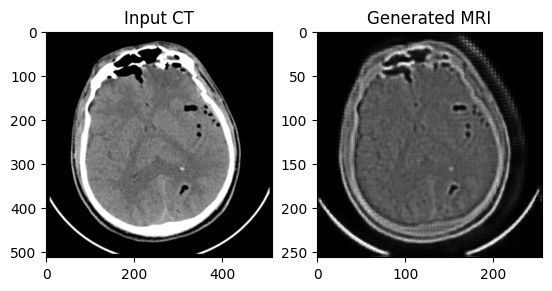

In [13]:
from keras.utils import custom_object_scope

# Register the custom layers
custom_objects = {
    "BioPhysicalLayer": BioPhysicalLayer,
    "NeuroSymbolicLayer": NeuroSymbolicLayer,
    "ReflectionPadding2D": ReflectionPadding2D,
    "InstanceNormalization": InstanceNormalization,
}

# Load the model inside the custom_object_scope
with custom_object_scope(custom_objects):
    model = keras.models.load_model("bpnsgm_ct_to_mri.h5", compile=False)


def preprocess_image(image_path, img_size=(256, 256)):
    img = Image.open(image_path).convert('L').resize(img_size)
    img_array = (np.array(img) / 127.5) - 1.0  # Normalize to [-1, 1]
    img_array = img_array[..., np.newaxis]     # Add channel dimension
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


def postprocess_image(img_tensor):
    img_array = (img_tensor[0, ..., 0] + 1.0) * 127.5  # Convert back to [0, 255]
    return Image.fromarray(np.clip(img_array, 0, 255).astype(np.uint8))

def ct_to_mri(ct_image_path, output_path="mri_result.png"):
    ct_input = preprocess_image(ct_image_path)
    mri_output = model.predict(ct_input)
    mri_image = postprocess_image(mri_output)
    mri_image.save(output_path)
    print(f"Saved MRI image to: {output_path}")

    plt.subplot(1, 2, 1)
    plt.title("Input CT")
    plt.imshow(Image.open(ct_image_path).convert('L'), cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.title("Generated MRI")
    plt.imshow(mri_image, cmap='gray')
    plt.show()

if __name__ == "__main__":
    ct_image_path = "/kaggle/input/ct-mri/Dataset/unseen_demo_images/ct/ct75.png"  
    ct_to_mri(ct_image_path)
